In [1]:
import sys 
sys.path.append("../")
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 
from kalman_ruls.data.dataprep import DataPrep 
from kalman_ruls.networks.encoders import * 
from kalman_ruls.networks.measurement_models import * 
from kalman_ruls.networks.transition_models import * 
from kalman_ruls.networks.DVAE import Kalman_DVAE
from kalman_ruls.data.utils import sliding_window, win_to_seq
from training import Trainer
from testing import *
import json 
import time  # importing time itself 

%matplotlib inline 
tf.keras.backend.set_floatx("float64")

In [2]:
sb.set_theme()

In [3]:
# --- Get Testing data ---
PATH = "..\\CMAPSS"
dataset = "FD001"
prep_class = DataPrep(PATH, dataset)

if dataset == "FD001" or dataset == "FD003":
    prep_class.op_normalize(K=1)    # K=1 normalization, K=6 operating condition norm 
else: 
    prep_class.op_normalize(K=6) 

max_rul = 130 
T = 40 
bs = 150 

x_train, y_train, t_train = prep_class.prep_data(prep_class.ntrain, T, max_rul)
x_train, y_train, t_train, x_valid, y_valid, t_valid = prep_class.valid_set(x_train, y_train, t_train)
x_test, y_test, t_test = prep_class.prep_test(prep_class.ntest, prep_class.RUL, max_rul)

train_loader, valid_loader = prep_class.get_dataloaders(bs, x_train, t_train, y_train, x_valid, t_valid, y_valid)

In [4]:
xdim = list(train_loader)[0][0].shape[-1]
ydim = list(train_loader)[0][1].shape[-1]
zdim = 2 
hdim = 50
K = 2 

transition = MixedTransition(zdim, K=K, hdim=hdim)
measurement = MixedMeasurement(zdim, ydim, K=K, hdim=hdim)
encoder = BidirectionalGRU(xdim, hdim, zdim, encode_d=True)

model = Kalman_DVAE(encoder, transition, measurement)

save_path = "saved_models/KRUL"
trainer = Trainer(lr=1e-3, alpha=0.4)

In [5]:
epochs = 100
trainer.train_model(epochs, train_loader, valid_loader, model, save_path, replay=True)

Epoch: 1/100, nll loss: 31626.5619, valid nll: 12429.4348, new best loss, saving model in saved_models/KRUL ...
Epoch: 10/100, nll loss: 200.1545, valid nll: 223.4076, new best loss, saving model in saved_models/KRUL ...
Epoch: 20/100, nll loss: 156.8124, valid nll: 190.7947, new best loss, saving model in saved_models/KRUL ...
Epoch: 30/100, nll loss: 142.2072, valid nll: 177.6030, new best loss, saving model in saved_models/KRUL ...
Epoch: 40/100, nll loss: 136.8434, valid nll: 170.4250, new best loss, saving model in saved_models/KRUL ...
Epoch: 50/100, nll loss: 134.5365, valid nll: 167.4401, new best loss, saving model in saved_models/KRUL ...
Epoch: 60/100, nll loss: 133.8435, valid nll: 166.8553, new best loss, saving model in saved_models/KRUL ...
Epoch: 70/100, nll loss: 132.0274, valid nll: 165.6481, new best loss, saving model in saved_models/KRUL ...
Epoch: 80/100, nll loss: 129.8195, valid nll: 163.1357, new best loss, saving model in saved_models/KRUL ...
Epoch: 90/100, n

In [7]:
model.load_weights(save_path) 
results = test_model(model, x_test, t_test, y_test, T)

In [8]:
print("RMSE: ", results["r_RMSE"])
print("score: ", results["score"])

RMSE:  10.710048995633015
score:  434.9087786051895


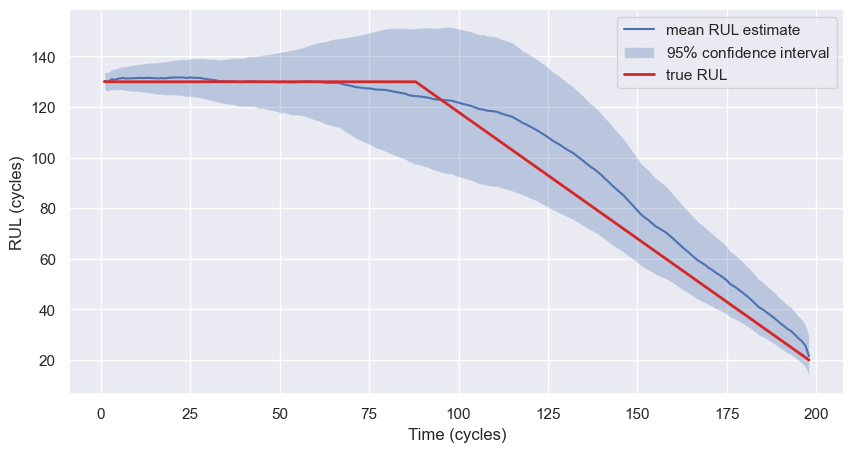

In [10]:
unit = 100
t = results["times"][unit-1]
lower_bound = results["r_mean"][unit-1] - results["r_stds"][unit-1]*2
upper_bound = results["r_mean"][unit-1] + results["r_stds"][unit-1]*2

plt.figure(figsize=(10,5))
plt.plot(t, results["r_mean"][unit-1], label="mean RUL estimate")
plt.fill_between(t, upper_bound, lower_bound, alpha=0.3, label="95$\%$ confidence interval")
plt.plot(t, results["r_true"][unit-1], lw=2, label="true RUL", color="tab:red")

plt.xlabel("Time (cycles)")
plt.ylabel("RUL (cycles)")
plt.legend()
plt.show()

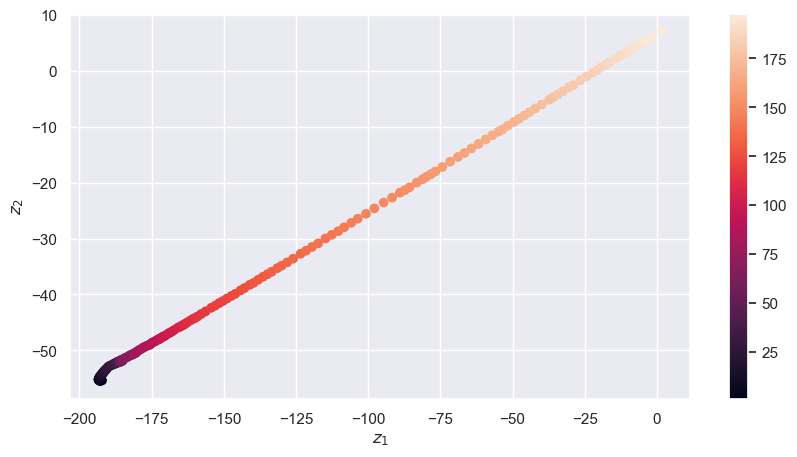

In [11]:
z_mean = results["z_mean"][unit-1]

plt.figure(figsize=(10,5))
plt.scatter(z_mean[:,0], z_mean[:,1], c=t)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.colorbar()
plt.show()

In [12]:
_, r_final, r_fin_est, r_fin_std, max_time = get_final_ruls(results)

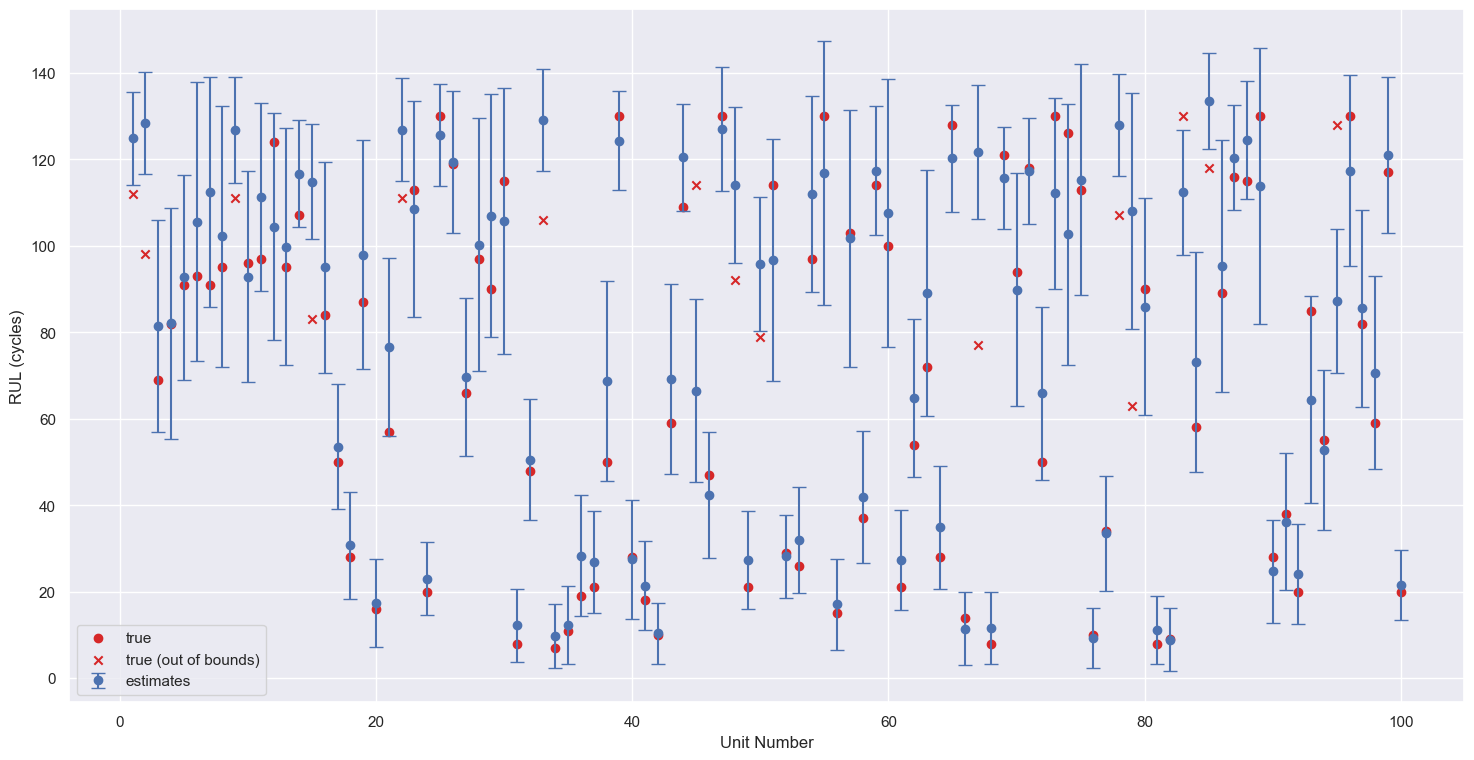

In [13]:
units = r_final.shape[0]
unit_list = np.linspace(1, units, units)
bound = 2*r_fin_std
out_of_bounds = (r_final < (r_fin_est - bound)) + (r_final > (r_fin_est + bound))
in_bounds = (1 - out_of_bounds).astype(np.bool_)

plt.figure(figsize=(18,9))
plt.scatter(unit_list[in_bounds], r_final[in_bounds], marker="o", color="tab:red", label="true")
plt.errorbar(unit_list, r_fin_est, bound, capsize=5., fmt="o", label="estimates")
plt.scatter(unit_list[out_of_bounds], r_final[out_of_bounds], marker="x", color="tab:red", label="true (out of bounds)")

plt.xlabel("Unit Number")
plt.ylabel("RUL (cycles)")
plt.legend()
plt.show()